# ARIMA  RSPM

 ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:<br>

<ol>
<li><b>Number of AR (Auto-Regressive) terms (p):</b> AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).<br></li>
<li><b>Number of MA (Moving Average) terms (q):</b> MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.<br></li>
<li><b>Number of Differences (d):</b> These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.</li>
</ol>

## Import required packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dateutil.parser import parse
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from scipy.stats import chisquare
import itertools
import warnings

## Importing the dataset into the dataframe

In [2]:
df = pd.read_csv('abc.csv', parse_dates = ['date'],index_col='date')
df.head()

,so2,no2,rspm,spm
date,,,,
2004-01-01,6.433505,58.231014,238.330000,398.000000
2004-01-02,6.433505,58.231014,182.915000,346.500000
2004-01-03,6.433505,58.231014,136.960411,343.926778
2004-01-04,6.433505,58.231014,136.960411,343.926778
2004-01-05,6.433505,58.231014,160.000000,340.000000


## Extracting the pollutant SO2 to different dataframe

Here we are creating an ARIMA model for the pollutant SO2. Thus a dataframe containing the concentration of SO2 is generated.

In [3]:
dfcopy = df.copy()
df_rspm = pd.DataFrame()
df_rspm = dfcopy.drop(['no2','so2','spm'], axis=1)
df_rspm.head()

,rspm
date,
2004-01-01,238.330000
2004-01-02,182.915000
2004-01-03,136.960411
2004-01-04,136.960411
2004-01-05,160.000000


## Dividing the  dataset into training and testing data

Here we are splitting our dataset into 75% - 25% for training and testing data respectively. 

In [4]:
#Defining training set
train = df_rspm[:'2012-12-31']
train.size

3288

In [5]:
#Defining testing set
test = df_rspm['2013-01-01':]
test.size

1095

## Plotting ACF and PACF plots

Through rough intuition we have come across the idea that $d=0$ since the dataset is stationary and there is no need for differencing. In order to guess the value of $p$ and $q$ we can plot the partial auto correlation and the auto correlation graphs respectively.

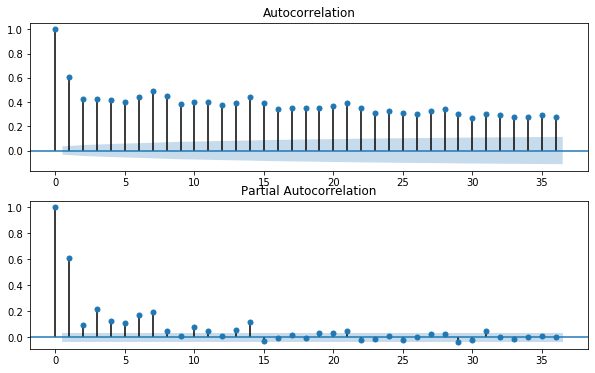

In [6]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(211)
fig = plot_acf(train, ax=ax1, title="Autocorrelation") 
ax2 = fig.add_subplot(212)
fig = plot_pacf(train, ax=ax2, title="Partial Autocorrelation")

Looking at the graphs it makes sense to guess the $p$ and $q$ values to be $3$ and $3$ respectively. However, in order to get a better quantitative idea of the parameters, we will use grid search technique to find the optimal combination of hyperparameters.

## Parameter estimation using grid search

This step is parameter Selection for our ARIMA Time Series Model. Our goal here is to use a “grid search” to find the optimal set of parameters that yields the best performance for our model.<br>

In order to find optimal parameters we define a range over which the parameters need to be estimated. In this example, the range would be $0, 1, 2, 3, 4, 5, 6$. Using the <b>product()</b> function in <b>itertools</b> library all possible combinaton of parameters are enumerated.

In [7]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

Using the above list of all possible parameters, we build ARIMA models using the <b>ARIMA()</b> function in the statsmodels library. For each ARIMA model, the hyperparameters and the <b>AIC(Akaike Information Critera)</b> value of the model are stored in a dataframe named param_df

In [8]:
warnings.filterwarnings('ignore')

param_df = pd.DataFrame(columns=['Parameter', 'AIC'])

i=0
for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        param_df.loc[i] = [param, model_arima_fit.aic]
        i = i + 1
    except:
        continue

The set of parameters that give the minimum value of AIC are considered to be the optimal set of parameters.

In [9]:
param_df[param_df['AIC']==param_df['AIC'].min()]

,Parameter,AIC
7,"(1, 1, 1)",36372.805152


## Building the ARIMA model

In [25]:
model = ARIMA(train, order = (1,0,1))
results = model.fit()

#Printing the summary of ARIMA model
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                   rspm   No. Observations:                 3288
Model:                     ARMA(1, 1)   Log Likelihood              -18292.446
Method:                       css-mle   S.D. of innovations             63.073
Date:                Thu, 02 Apr 2020   AIC                          36592.891
Time:                        19:56:24   BIC                          36617.283
Sample:                    01-01-2004   HQIC                         36601.624
                         - 12-31-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        190.4580      9.025     21.103      0.000     172.769     208.147
ar.L1.rspm     0.9747      0.006    169.131      0.000       0.963       0.986
ma.L1.rspm    -0.7904      0.020    -40.235      0.0

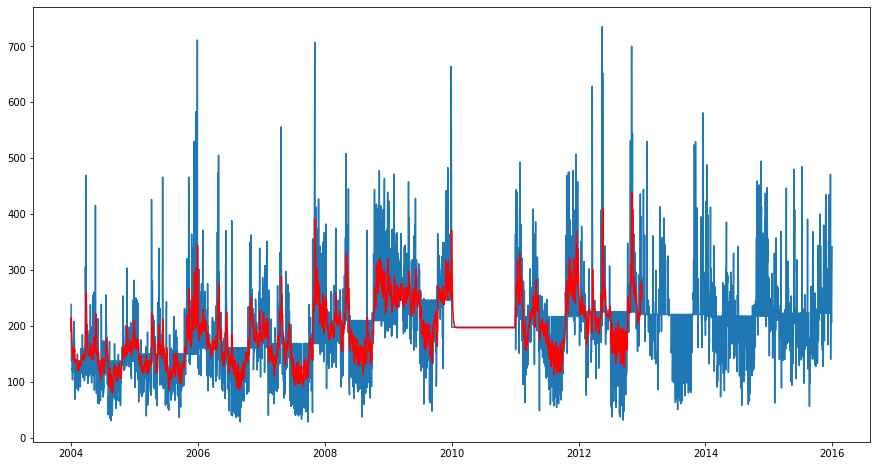

In [26]:
#Plotting the fitted model against the original dataset
plt.figure(figsize =(15,8))
plt.plot(df_rspm)
plt.plot(results.fittedvalues, color ='red')

## Predicting future values 

In [32]:
model_predictions, SE, interval = results.forecast(steps = 1095, alpha = 0.05)

In [33]:
prediction_df = pd.DataFrame(columns=['Predictions', 'Lower', 'Upper'], index=df_rspm.index[3288:])
prediction_df['Predictions'] = model_predictions

for i in range(0, 1095):
    prediction_df['Lower'][i] = interval[i][0]
    prediction_df['Upper'][i] = interval[i][1]

prediction_df.head()

,Predictions,Lower,Upper
date,,,
2013-01-01,243.769922,120.148,367.392
2013-01-02,242.421960,116.717,368.127
2013-01-03,241.108080,113.456,368.76
2013-01-04,239.827420,110.352,369.302
2013-01-05,238.579142,107.396,369.763


## Comparing Observed and Predicted values

In [34]:
lower = np.array(prediction_df['Lower'], dtype=float)
upper = np.array(prediction_df['Upper'], dtype=float)

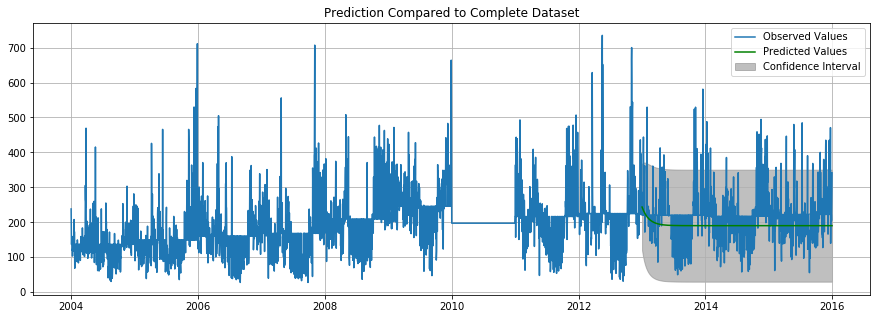

In [35]:
plt.figure(figsize =(15,5))
plt.plot(df_rspm['rspm'], label='Observed Values')
plt.plot(prediction_df['Predictions'], color='green', label='Predicted Values')
plt.fill_between(prediction_df.index, lower, upper, color='grey', alpha=0.5, label='Confidence Interval')
plt.title('Prediction Compared to Complete Dataset')
plt.grid()
plt.legend()
plt.show()

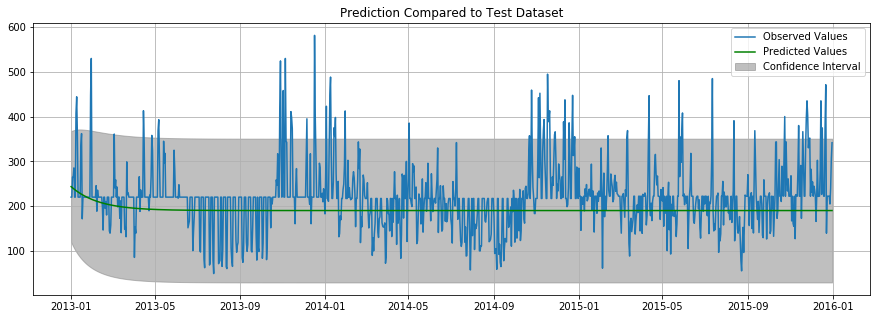

In [36]:
plt.figure(figsize =(15,5))
plt.plot(df_rspm['rspm'][3288:], label='Observed Values')
plt.plot(prediction_df['Predictions'], color='green', label='Predicted Values')
plt.fill_between(prediction_df.index, lower, upper, color='grey', alpha=0.5, label='Confidence Interval')
plt.title('Prediction Compared to Test Dataset')
plt.grid()
plt.legend()
plt.show()

<Figure size 1080x720 with 0 Axes>

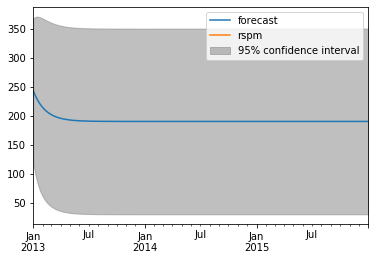

In [17]:
plt.figure(figsize =(15,10))
results.plot_predict(start = '2013-01-01', end = '2015-12-31')
plt.show()

## Chi-Square test for goodness of fit

The Chi-Squared statistic is used to test the goodness of the fit. It considers the following:

<ul>
<li><b>Null Hypothesis or $H0$:</b> The observed values are likely to have been from a distribution defined by the expected values.</li>
<li><b>Alternative Hypothesis or $H1$:</b> The observed values are not likely to have been from a distribution defined by the expected values.</li>
</ul>
The p value of this statistic defines the probability of observing the observed data from the distribution represented by the expected one.

In [18]:
observed_values = list(df_rspm['rspm'][3288:])
predicted_values = list(prediction_df['Predictions'])

In [19]:
goodness_of_fit = chisquare(observed_values, f_exp=predicted_values)

In [20]:
print("Chi-Squared Statistic - ", goodness_of_fit[0])
print("p Value - ", goodness_of_fit[1])

Chi-Squared Statistic -  33610.27333481301
p Value -  0.0


The high p value indicates that the observed values could have been derived from the ARIMA model built. Thus it can be concluded that the model fits the data with reasonably well accuracy.

### References

<ul>
    <li><a>https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b</a></li>
    <li><a>https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/</a></li>
    <li><a>https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/</a></li>
    <li><a>https://people.duke.edu/~rnau/411arim3.htm</a></li>
    <li><a>https://www.quantstart.com/articles/Autoregressive-Integrated-Moving-Average-ARIMA-p-d-q-Models-for-Time-Series-Analysis/</a></li>
    <li><a>https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html</a></li>
    <li><a>https://otexts.com/fpp2/</a><li>
</ul>